<a href="https://colab.research.google.com/github/lingyixu/CS523-Deep-Learning/blob/main/GNN/GAT_Multilabel_Classification_5Fold_CV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Load packages

In [1]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!pip install torchmetrics

2.0.0+cu118
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [46]:
import torch.nn.functional as F
import torch_geometric
from torch_geometric.data import Dataset, Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, GATConv, global_mean_pool
from torch_geometric.transforms import RandomNodeSplit
from torch_geometric.utils import index_to_mask, mask_to_index, remove_self_loops, to_networkx
from torchmetrics.classification import BinaryHammingDistance

In [3]:
import pandas as pd
import numpy as np
import json
import glob
import random
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.manifold import TSNE
from sklearn.model_selection import KFold, train_test_split
import networkx as nx

In [4]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [5]:
from google.colab import drive
drive.mount('/content/drive')
drive_path = '/content/drive/Shareddrives/CS523/lastFM-data/'

Mounted at /content/drive


### Load dataset: LastFM

In [6]:
df_feat = pd.read_json(drive_path + 'processed_feature.json')   # load features
arr_feat = df_feat.T.values
df_edge = pd.read_csv(drive_path + 'lastfm_asia_edges.csv')   # load edge indices
arr_edge = df_edge.T.values
df_tar = pd.read_csv(drive_path + 'lastfm_asia_target.csv', index_col=0)   # load targets
arr_tar = df_tar.values

num_nodes = arr_feat.shape[0]
num_features = arr_feat.shape[1]
num_classes = len(df_tar.target.unique())
classes = df_tar.target.sort_values().unique()

print('Dataset:')
print('====================')
print(f'Number of nodes: {num_nodes}')
print(f'Number of features: {num_features}')
print(f'Number of edges: {arr_edge.shape[1]}')
print(f'Number of distinct regions: {num_classes}')
print(f'All region classes: {classes}')

Dataset:
Number of nodes: 7624
Number of features: 7842
Number of edges: 27806
Number of distinct regions: 18
All region classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]


In [7]:
graph_metadata = {'data': arr_feat, 'edge_index': arr_edge, 'label': arr_tar}

### Create GraphDataset

In [8]:
class GraphDataset(Dataset):
    
    def __init__(self, root, out_dir, metadata, transform=None, pre_transform=None, pre_filter=None):
        self.root = root
        self.out_dir = out_dir
        self.metadata = metadata
        super(GraphDataset, self).__init__(root, transform, pre_transform, pre_filter)

    @property
    def raw_file_names(self):
        return root

    @property
    def processed_file_names(self):
        return glob.glob(f'{self.out_dir}/*.pt')

    def download(self):
        pass
    
    
    def process(self):

        self.node_features = torch.tensor(self.metadata['data'], dtype=torch.float)
        self.edge_index = torch.tensor(self.metadata['edge_index'], dtype=torch.int64)
        self.label = torch.tensor(self.metadata['label'], dtype=torch.int64)
        # self.all_features = torch.concat([self.node_features, self.label], dim=1)   # take region as an additional feature
        
        data = Data(x = self.node_features,
                    edge_index = self.edge_index,
                    # edge_attr = None,
                    y = self.label)

        torch.save(data, f'{self.out_dir}/data.pt')

    def len(self):
        return self.node_features.shape[0]

    def get(self):
        data = torch.load(f'{self.out_dir}/data.pt')
        return data

In [9]:
root = ''
out_dir = 'graph_data'
os.mkdir(out_dir)
metadata = graph_metadata
dataset = GraphDataset(root=root, out_dir=out_dir, metadata=metadata)

Processing...
Done!


In [10]:
# inspect the graph dataset
data = dataset.get()
print()
print(data)
print('=============================================================')
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')


Data(x=[7624, 7842], edge_index=[2, 27806], y=[7624, 1])
Number of nodes: 7624
Number of edges: 27806


In [11]:
# set data to cuda
data.to(device)

Data(x=[7624, 7842], edge_index=[2, 27806], y=[7624, 1])

### Train/valid/test split for 5-fold cross validation

In [12]:
def graphdataset_split(dataset, n_fold):

    X = np.arange(num_nodes)
    splits = KFold(n_fold, shuffle=True, random_state=42)   # fix the seed to make the split reproducible
    splits.split(X)
    
    train_sets = []
    valid_sets = []
    test_sets = []

    for train_index, test_index in splits.split(X):
        train_index, valid_index = train_test_split(train_index, test_size=0.1)
        train_sets.append(list(train_index))
        valid_sets.append(list(valid_index))
        test_sets.append(list(test_index))

    return train_sets, valid_sets, test_sets

In [13]:
n_fold = 5
train_sets, valid_sets, test_sets = graphdataset_split(data, n_fold)

for i in range(n_fold):
    print('================')
    print(f'Fold {i+1}:')
    print(f'Train nodes: {len(train_sets[i])}')
    print(f'Valid nodes: {len(valid_sets[i])}')
    print(f'Test nodes: {len(test_sets[i])}')

Fold 1:
Train nodes: 5489
Valid nodes: 610
Test nodes: 1525
Fold 2:
Train nodes: 5489
Valid nodes: 610
Test nodes: 1525
Fold 3:
Train nodes: 5489
Valid nodes: 610
Test nodes: 1525
Fold 4:
Train nodes: 5489
Valid nodes: 610
Test nodes: 1525
Fold 5:
Train nodes: 5490
Valid nodes: 610
Test nodes: 1524


In [14]:
# create masks
train_masks = []
valid_masks = []
test_masks = []

for i in range(n_fold):
    
    train_mask = index_to_mask(torch.tensor(train_sets[i]), size=num_nodes).to(device)
    valid_mask = index_to_mask(torch.tensor(valid_sets[i]), size=num_nodes).to(device)
    test_mask = index_to_mask(torch.tensor(test_sets[i]), size=num_nodes).to(device)
    
    train_masks.append(train_mask)
    valid_masks.append(valid_mask)
    test_masks.append(test_mask)

### Build GNN

In [15]:
# ref: https://github.com/pyg-team/pytorch_geometric/issues/3550
class GAT(torch.nn.Module):
    
    def __init__(self, hidden_channels1, hidden_channels2, hidden_channels3):
        super().__init__()
        self.conv1 = GATConv(num_features, hidden_channels1)
        self.conv2 = GATConv(hidden_channels1, hidden_channels2)
        self.conv3 = GATConv(hidden_channels2, hidden_channels3)
        self.linear = torch.nn.Linear(hidden_channels3, num_features)

    def forward(self, x, edge_index, train_mask):

        # out = torch.zeros_like(x)
        train_nodes = mask_to_index(train_mask)
        untrain_nodes = mask_to_index(~train_mask)
        x_masked = x.clone()
        x_masked[untrain_nodes] = -1   # set all un-training node features to -1

        out = self.conv1(x_masked, edge_index)
        out = out.relu()
        out = self.conv2(out, edge_index)
        out = out.relu()
        out, w = self.conv3(out, edge_index, return_attention_weights=True)
        out = out.relu()
        # x = F.dropout(x, p=0.5)
        out = self.linear(out)
        out = out.sigmoid()
        return out, w

In [16]:
criterion = torch.nn.BCEWithLogitsLoss()

In [17]:
# model = GAT(4096, 4096, 2048, train_masks[0], valid_masks[0])
# model.to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=2e-4, weight_decay=5e-4)
# out = model(data.x, data.edge_index)
# loss = criterion(out[test_mask], data.x[test_mask]).cpu().detach().item()
# metric = BinaryHammingDistance(task='multilabel', num_labels=2).to(device)
# acc = 1 - metric(out[valid_masks[0]], data.x[valid_masks[0]])

### Model training and testing

In [18]:
# set params
hidden_channels1 = 4096
hidden_channels2 = 4096
hidden_channels3 = 2048
lr = 2e-4
weight_decay = 5e-4
epoch = 20
save_results = False

In [19]:
def train(model, train_mask, test_mask):   # use test_mask for backprop only
    model.train()
    optimizer.zero_grad()
    out, _ = model(data.x, data.edge_index, train_mask)
    loss = criterion(out[test_mask], data.x[test_mask])
    loss.backward()
    optimizer.step()
    # return loss.detach().cpu().item()

def test(model, train_mask, test_mask):   # use test_mask for calculating accuracy only
    model.eval()
    out, w = model(data.x, data.edge_index, train_mask)
    loss = criterion(out[test_mask], data.x[test_mask]).cpu().detach().item()
    metric = BinaryHammingDistance(task='multilabel', num_labels=2).to(device)   # measure average disagreement in a binary task
    acc = 1 - metric(out[test_mask], data.x[test_mask])
    return out, w, loss, acc.cpu().item()

In [30]:
# cross validation
train_acc_all = []
test_acc_all = []
train_loss_all = []
test_loss_all = []

for i in range(n_fold):   # loop through folds

    print(f'===== Fold {i+1} ======')
    
    # initialize model and optimizer
    model = GAT(hidden_channels1, hidden_channels2, hidden_channels3)
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    # accuracy per epoch
    train_acc_epoch = []
    test_acc_epoch = []
    # loss per epoch
    train_loss_epoch = []
    test_loss_epoch = []

    for e in range(epoch):   # loop through epochs
        
        train(model, train_masks[i], valid_masks[i])
        _, _, train_loss, train_acc = test(model, train_masks[i], valid_masks[i])
        out, w, test_loss, test_acc = test(model, train_masks[i], test_masks[i])
        
        # save loss and accuracy history
        train_acc_epoch.append(train_acc)
        test_acc_epoch.append(test_acc)
        train_loss_epoch.append(train_loss)
        test_loss_epoch.append(test_loss)
                
        # save model, output, and attention
        if (e == epoch-1) and (save_results==True):
            torch.save(model, f'/content/drive/Shareddrives/CS523/Notebooks/model/GAT/fold_{i+1}.pt')
            torch.save(out, f'/content/drive/Shareddrives/CS523/Notebooks/output/GAT/fold_{i+1}.pt')
            edges = w[0]
            weight = w[1]
            edge, edge_weight = remove_self_loops(edges, weight)
            torch.save(edge_weight, f'/content/drive/Shareddrives/CS523/Notebooks/output/GAT/attention_fold_{i+1}.pt')

        print(f'Epoch: {e+1:02d}, Train loss: {train_loss:.4f}, Test loss: {test_loss:.4f}')

        torch.cuda.empty_cache()

    train_acc_all.append(train_acc_epoch)
    test_acc_all.append(test_acc_epoch)
    train_loss_all.append(train_loss_epoch)
    test_loss_all.append(test_loss_epoch)

===== Fold 1 ======
Epoch: 01, Train loss: 0.9413, Test loss: 0.9399
Epoch: 02, Train loss: 0.9078, Test loss: 0.9069
Epoch: 03, Train loss: 0.8442, Test loss: 0.8433
Epoch: 04, Train loss: 0.7758, Test loss: 0.7753
Epoch: 05, Train loss: 0.7299, Test loss: 0.7296
Epoch: 06, Train loss: 0.7072, Test loss: 0.7071
Epoch: 07, Train loss: 0.6980, Test loss: 0.6980
Epoch: 08, Train loss: 0.6952, Test loss: 0.6952
Epoch: 09, Train loss: 0.6945, Test loss: 0.6945
Epoch: 10, Train loss: 0.6943, Test loss: 0.6943
Epoch: 11, Train loss: 0.6943, Test loss: 0.6942
Epoch: 12, Train loss: 0.6942, Test loss: 0.6941
Epoch: 13, Train loss: 0.6940, Test loss: 0.6940
Epoch: 14, Train loss: 0.6939, Test loss: 0.6939
Epoch: 15, Train loss: 0.6939, Test loss: 0.6939
Epoch: 16, Train loss: 0.6938, Test loss: 0.6938
Epoch: 17, Train loss: 0.6937, Test loss: 0.6937
Epoch: 18, Train loss: 0.6936, Test loss: 0.6936
Epoch: 19, Train loss: 0.6935, Test loss: 0.6935
Epoch: 20, Train loss: 0.6935, Test loss: 0.6935


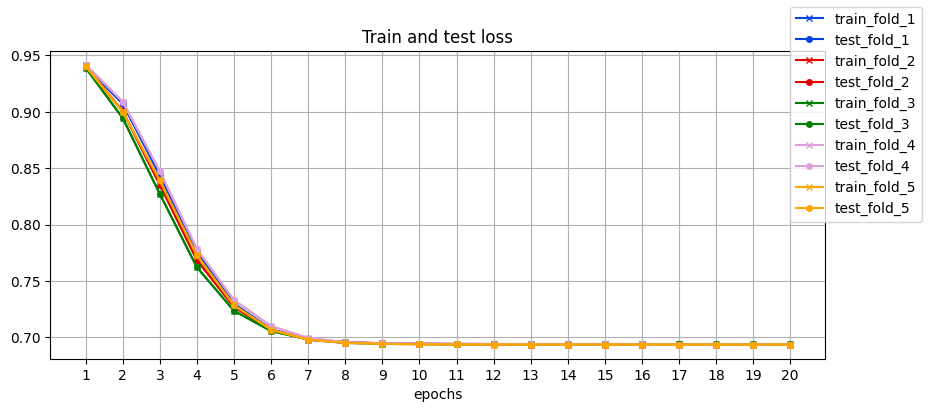

In [31]:
# plot train and test loss
fig, ax = plt.subplots(figsize=(10,4))
colors = ['#0343DF', '#E50000', '#008000', '#DDA0DD', '#FFA500']
for i in range(n_fold):
    ax.plot(range(1,len(train_loss_all[i])+1), train_loss_all[i], '-x', markersize=4, label=f'train_fold_{i+1}', color=colors[i])
    ax.plot(range(1,len(test_loss_all[i])+1), test_loss_all[i], '-o', markersize=4, label=f'test_fold_{i+1}', color=colors[i])
ax.set_xticks(np.arange(1, epoch+1))
ax.grid()
ax.set_title('Train and test loss')
ax.set_xlabel('epochs')
fig.legend()
fig.show()

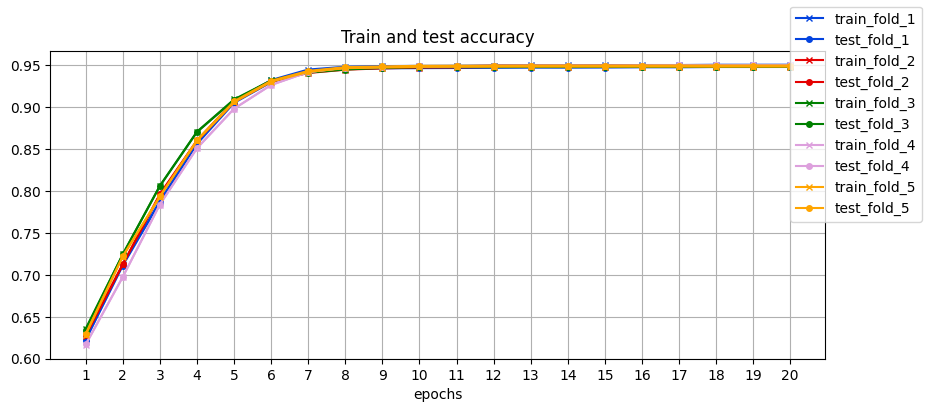

In [32]:
# plot train and test accuracy
fig, ax = plt.subplots(figsize=(10,4))
for i in range(n_fold):
    ax.plot(range(1,len(train_acc_all[i])+1), train_acc_all[i], '-x', markersize=4, label=f'train_fold_{i+1}', color=colors[i])
    ax.plot(range(1,len(test_acc_all[i])+1), test_acc_all[i], '-o', markersize=4, label=f'test_fold_{i+1}', color=colors[i])
ax.set_xticks(np.arange(1, epoch+1))
ax.grid()
ax.set_title('Train and test accuracy')
ax.set_xlabel('epochs')
fig.legend()
fig.show()

In [33]:
# print out average accuracy
acc_list = []
for i in range(n_fold):
    acc = test_acc_all[i][-1]
    acc_list.append(acc)
    print(f'Fold {i+1} test accuracy: {acc:.4f}')
print(f'Average accuracy: {np.mean(acc_list):.4f}')

Fold 1 test accuracy: 0.9478
Fold 2 test accuracy: 0.9495
Fold 3 test accuracy: 0.9480
Fold 4 test accuracy: 0.9497
Fold 5 test accuracy: 0.9495
Average accuracy: 0.9489


### Inspect all folds output

In [37]:
# combine and reorder the outputs
output_sorted = torch.zeros(num_nodes, num_features)

for i in range(n_fold):
    output = torch.load(f'/content/drive/Shareddrives/CS523/Notebooks/output/GAT/fold_{i+1}.pt')   # load back saved outputs
    output_masked = output[[test_masks[i]]].cpu().detach()
    print(f'Fold {i+1} output: {output_masked.shape[0]} nodes')
    output_sorted[test_masks[i]] = output_masked   # put output of each folder back to the original order

print('==============')
print(f'All folds output: {output_sorted.shape[0]} nodes')

Fold 1 output: 1525 nodes
Fold 2 output: 1525 nodes
Fold 3 output: 1525 nodes
Fold 4 output: 1525 nodes
Fold 5 output: 1524 nodes
All folds output: 7624 nodes


In [38]:
if save_results:
    torch.save(output_sorted, f'/content/drive/Shareddrives/CS523/Notebooks/output/GAT/all_folds.pt')

### Inspect edge weights

In [44]:
# load the weights
all_weights = []
for i in range(n_fold):
    weights = torch.load(f'/content/drive/Shareddrives/CS523/Notebooks/output/GAT/attention_fold_{i+1}.pt').cpu().detach()   # shape of num_edges x 1
    all_weights.append(weights)

In [53]:
# make a new graph dataset with edge_attr = edge_weight
# take fold 1 for example
class NewGraphDataset(Dataset):
    
    def __init__(self, root, out_dir, metadata, transform=None, pre_transform=None, pre_filter=None):
        self.root = root
        self.out_dir = out_dir
        self.metadata = metadata
        super(NewGraphDataset, self).__init__(root, transform, pre_transform, pre_filter)

    @property
    def raw_file_names(self):
        return root

    @property
    def processed_file_names(self):
        return glob.glob(f'{self.out_dir}/*.pt')

    def download(self):
        pass
    
    
    def process(self):

        self.node_features = torch.tensor(self.metadata['data'], dtype=torch.float)
        self.edge_index = torch.tensor(self.metadata['edge_index'], dtype=torch.int64)
        self.edge_attr = torch.tensor(self.metadata['edge_attr'], dtype=torch.float)
        self.label = torch.tensor(self.metadata['label'], dtype=torch.int64)
        
        data = Data(x = self.node_features,
                    edge_index = self.edge_index,
                    edge_attr = self.edge_attr,
                    y = self.label)

        torch.save(data, f'{self.out_dir}/data.pt')

    def len(self):
        return self.node_features.shape[0]

    def get(self):
        data = torch.load(f'{self.out_dir}/data.pt')
        return data

In [55]:
new_graph_metadata = {'data': arr_feat, 'edge_index': arr_edge, 'edge_attr': all_weights[0], 'label': arr_tar}
root = ''
new_out_dir = 'new_graph_data'
# os.mkdir(out_dir)
new_metadata = new_graph_metadata
new_dataset = NewGraphDataset(root=root, out_dir=new_out_dir, metadata=new_metadata)

Processing...
<ipython-input-53-7a5a261620d0>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.edge_attr = torch.tensor(self.metadata['edge_attr'], dtype=torch.float)
Done!


In [61]:
# inspect the new graph dataset
new_data = new_dataset.get()
print()
print(new_data)
print('=============================================================')
print(f'Number of nodes: {new_data.num_nodes}')
print(f'Number of edges: {new_data.num_edges}')


Data(x=[7624, 7842], edge_index=[2, 27806], edge_attr=[27806, 1], y=[7624, 1])
Number of nodes: 7624
Number of edges: 27806


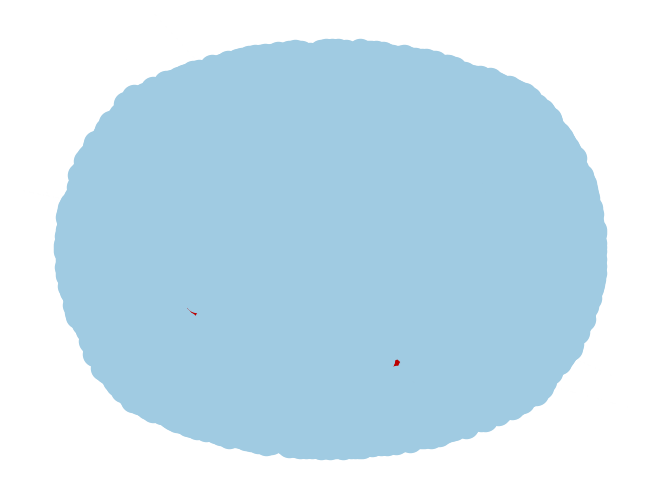

In [63]:
# simple visualization
# 太丑了！need to export to Gephi
G = to_networkx(new_data)
nx.draw(G, pos=nx.spring_layout(G), node_color='#A0CBE2', edge_color='#BB0000', width=2, edge_cmap=plt.cm.Blues, with_labels=False)
# plt.savefig('graph_fold_1.pdf')